# IRAM Data Example

Trey V. Wenger (c) December 2024

Here we test `bayes_cn_hfs` on some real IRAM 30-m data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+3.g8d34583.dirty


## Load the data

12CN-1/2 650
12CN-3/2 551
13CN-1/2 550
13CN-3/2 550


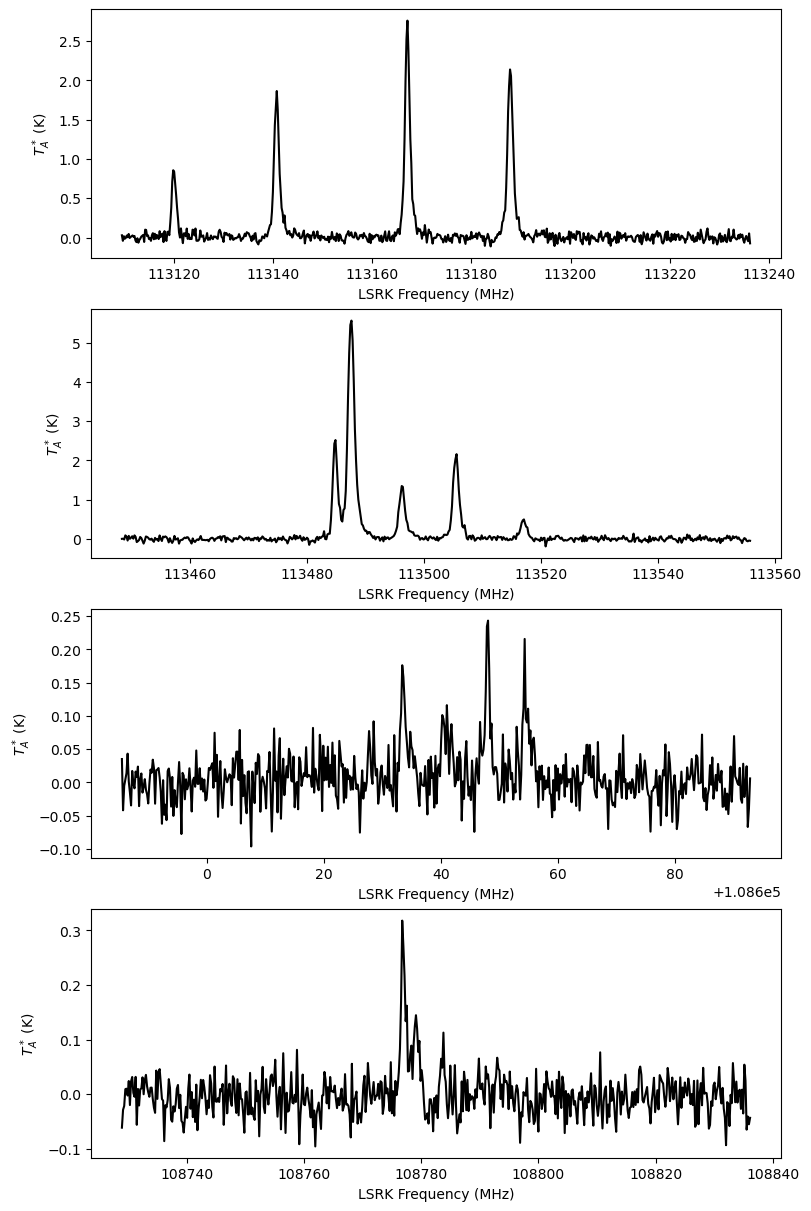

In [2]:
from bayes_spec import SpecData
import pickle

with open("iram_data.pkl", "rb") as f:
    iram_data = pickle.load(f)

labels = ["12CN-1/2", "12CN-3/2", "13CN-1/2", "13CN-3/2"]
data = {
    label: SpecData(
        iram_data[f"frequency_{label}"][500:-500],
        iram_data[f"spectrum_{label}"][500:-500],
        iram_data[f"rms_{label}"],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_A^*$ (K)",
    )
    for label in labels
}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in labels if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, label in enumerate(labels):
    axes[i].plot(data[label].spectral, data[label].brightness, 'k-')
    axes[i].set_xlabel(data[label].xlabel)
    axes[i].set_ylabel(data[label].ylabel)

## Number of cloud components
We first explore the CN data, which have greater signal-to-noise, in order to constrain the optical depths, excitation temperatures, and number of cloud components. We assume non-thermal broadening is important, so we fix the kinetic temperature. We otherwise assume a non-LTE model with hyperfine anomalies. Therefore the assumption of a fixed kinetic temperature only biases our inference of the thermal line width.

In [3]:
from bayes_cn_hfs.cn_model import CNModel
from bayes_cn_hfs import get_molecule_data
from bayes_spec import Optimize

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

max_n_clouds = 5
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=0.78, # Main beam efficiency
    Feff=0.94, # Forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N0 = [12.0, 1.0], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = [1.75, 0.25], # mean and width of log10 cloud mean excitation temperature prior (K)
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [10.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log_boltz_factor_sigma = 0.1, # width of log Boltzmann factor hyperfine anomaly prior
    fix_log10_Tkin = 1.75, # assume a kinetic temperature
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Transition 113144.19 is constraining upper state 1 from lower state 0
Transition 113191.325 is constraining upper state 0 from lower state 0
Transition 113490.985 is constraining upper state 3 from lower state 0
Transition 113508.934 is constraining upper state 4 from lower state 0
Transition 113520.4215 is constraining upper state 2 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 1
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 113144.19 is constraining upper state 1 from lower state 0
Transition 113191.325 is constraining upper state 0 from lower state 0
Transition 113490.985 is constraining upper state 3 from lower state 0
Transition 113508.934 is constraining upper state 4 from lower state 0
Transition 113520.4215 is constraining upper state 2 from lower state 0
Transition 1

Check prior predictive.

Sampling: [12CN-1/2, 12CN-3/2, baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tex_mean_norm, log_boltz_factor_free_norm, log_boltz_factor_sigma_norm, velocity_norm]


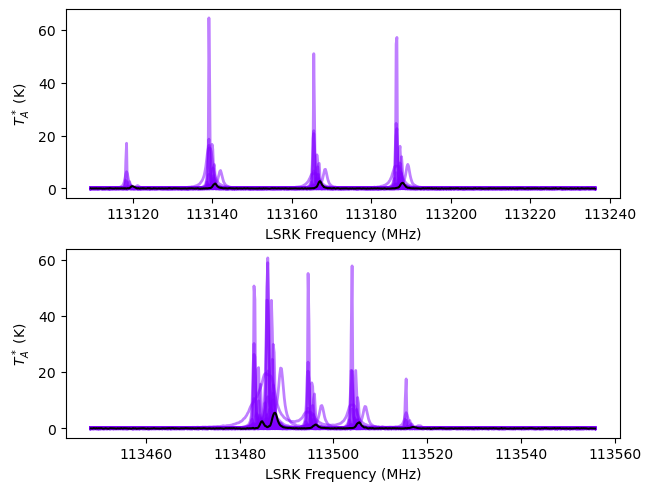

In [4]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

Approximate all models with variational inference.

In [5]:
start = time.time()
fit_kwargs = {
    "n": 15_000,
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.02,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.570e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 6100
Interrupted at 6,099 [40%]: Average Loss = 50,744


Output()

n_cloud = 1 BIC = -1.557e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 6100
Interrupted at 6,099 [40%]: Average Loss = 11,113


Output()

n_cloud = 2 BIC = -2.416e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 8800
Interrupted at 8,799 [58%]: Average Loss = 1.712e+15


Output()

n_cloud = 3 BIC = -2.957e+03

Approximating n_cloud = 4 posterior...


Output()

Finished [100%]: Average Loss = -1,496.6


Output()

n_cloud = 4 BIC = -3.152e+03

Approximating n_cloud = 5 posterior...


Output()

Finished [100%]: Average Loss = -1,427.7


Output()

n_cloud = 5 BIC = -2.901e+03

Runtime: 15.74 minutes


In [8]:
null_bic = opt.models[1].null_bic()
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

[95704.84851857 -1556.96189983 -2416.01605366 -2957.3194818
 -3152.10968321 -2901.32720749]


Let's compare the BICs to MCMC.

In [9]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.02,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 15_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.570e+04
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6100
Interrupted at 6,099 [40%]: Average Loss = 50,744
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, log10_N0_norm, log10_Tex_mean_norm, log_boltz_factor_sigma_norm, log_boltz_factor_free_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1748 seconds.


Adding log-likelihood to trace


Output()

There were 76 divergences in converged chains.
GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -1.665e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6100
Interrupted at 6,099 [40%]: Average Loss = 11,113
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1/2_norm, baseline_12CN-3/2_norm, log10_N0_norm, log10_Tex_mean_norm, log_boltz_factor_sigma_norm, log_boltz_factor_free_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 68 draw iterations (8_000 + 544 draws total) took 2811 seconds.


Adding log-likelihood to trace


Output()

There were 2 divergences in converged chains.
GMM converged to unique solution
4 of 8 chains appear converged.
n_cloud = 2 solution = 0 BIC = -2.793e+03

Sampling n_cloud = 3 posterior...


KeyboardInterrupt: 

In [ ]:
plt.plot(np.vstack([mean[isnan] for mean in tracker["std"]]))

In [ ]:
isnan = np.isnan(tracker["mean"][-1])

In [ ]:
np.vstack([mean[isnan] for mean in tracker["mean"]]).shape

In [ ]:
np.where(np.isnan(tracker["mean"][-1]))

In [ ]:
dir(opt.models[4].model)

In [ ]:
opt.models[4].model.initial_point()

In [ ]:
dir(advi)

In [ ]:
advi.state